In [1]:
import numpy as np
from scipy.signal import resample, butter, lfilters
from scipy.signal import welch
import matplotlib.pyplot as plt

In [22]:
class SignalProcessor:
    def __init__(self, input_path, output_path, if_freq, orig_sr, target_sr, block_size):
        self.input_path = input_path
        self.output_path = output_path
        self.if_freq = if_freq
        self.orig_sr = orig_sr
        self.target_sr = target_sr
        self.block_size = block_size  # Number of samples per chunk
        self.lp_cutoff_freq = min(if_freq, orig_sr / 2)  # Low-pass filter cutoff frequency
        self.num_channels = 4
        self.psds = []
        
    def low_pass_filter(self, signal):
        nyquist = 0.5 * self.orig_sr
        normal_cutoff = self.lp_cutoff_freq / nyquist
        b, a = butter(5, normal_cutoff, btype='low', analog=False)
        return lfilter(b, a, signal)

    def downconvert_to_baseband(self, chunk):
        t = np.arange(len(chunk)) / self.orig_sr
        complex_exponential = np.exp(-1j * 2 * np.pi * self.if_freq * t)
        mixed_signal = chunk * complex_exponential
        baseband_signal = self.low_pass_filter(mixed_signal)
        return baseband_signal

    def calculate_psd(self, channel_data):
        """
        Calculates the Power Spectral Density (PSD) for each channel.

        :param channel_data: a numpy array of channel data.
        :param sample_rate: Sample rate in Hz.
        :param dwell_time: Dwell time for the PSD calculation.
        :return: A list of PSDs for each channel.
        """

        # Calculate the PSD for each channel
        # fft_channel_data = np.fft.fft(channel_data)
        # # conjugate of the second half of the fft
        # # fft_channel_data_conj = np.conjugate(fft_channel_data[1:int(len(fft_channel_data) / 2)])
        # frequency = np.fft.fftfreq(len(fft_channel_data), 1 / self.orig_sr)
        # power = np.abs(fft_channel_data) ** 2
        frequency, power = welch(channel_data, fs=self.target_sr, nperseg=1024, noverlap=512, nfft=1024)
        return (frequency, power)
    
    def plot_psd(self, psds):
        """
        Plots the Power Spectral Density for each channel.

        :param psds: A list of PSDs for each channel.
        """
        for i, (frequency, power) in enumerate(psds):
            plt.figure()
            plt.semilogy(frequency, power, '.')
            plt.title(f'Channel {i+1} Power Spectral Density')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power/Frequency (dB/Hz)')
            plt.grid(True)
        plt.show()
    
    def process_chunks(self):
        block_num_max = 10
        with open(self.input_path, 'rb') as infile:
            block_num = 0
            while True:
                # Read a chunk of the file
                chunk = np.fromfile(infile, dtype=np.int8, count=self.num_channels*self.block_size)
                if chunk.size == 0:
                    break  # End of file
                
                # Each element in chunk is a array of 8-bit samples from 4 separate channels
                # reshape to 4xN array
                # channel_chunk = chunk.reshape(4, -1)
                reshaped_data = chunk.reshape((self.block_size, self.num_channels))
                channel_data_array = reshaped_data.transpose()
                channel_data = channel_data_array[0]
                baseband_chunk = self.downconvert_to_baseband(channel_data)

                # Upsample the baseband signal
                upsampled_chunk = resample(baseband_chunk, int(len(baseband_chunk) * self.target_sr / self.orig_sr))
                self.psds.append(self.calculate_psd(upsampled_chunk))
                # # Write the processed chunk to the output file
                # output_block_path = f"{self.output_path}_chunk{block_num}.bin"
                # upsampled_chunk.astype(np.float32).tofile(output_block_path)

                block_num += 1
                if block_num == block_num_max:
                    break
                print(f"Processed chunk {block_num}")
        self.plot_psd(self.psds)

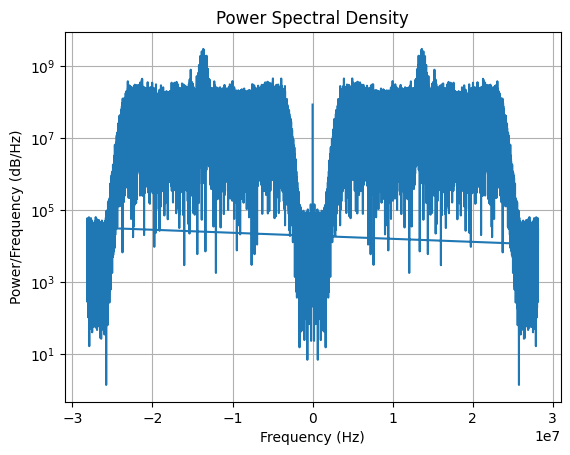

In [13]:
from scipy.fft import fft, fftfreq, rfft, rfftfreq

input_file_path = '/home/cosgrma/workspace/sergeant/data/mcode_8bit_4chan_1min.bin'
output_file_base_path = 'path_to_output_baseband'
if_freq = 13.68e6  # Intermediate frequency
original_sample_rate = 56.32e6  # Original sample rate
target_sample_rate = 58e6  # Target sample rate
T = 1e-3
num_channels = 4
block_size = int(original_sample_rate * T)  # Number of samples per block

# Open the input file and process the chunks
inputfile = open(input_file_path, 'rb')

# Read a block of data
chunk = np.fromfile(inputfile, dtype=np.int8, count=num_channels*block_size)
# reshape to 4, 56320
# channel_chunk = chunk.reshape(num_channels, -1)
reshaped_data = chunk.reshape((block_size, num_channels))
channel_data_array = reshaped_data.transpose()
channel_data = channel_data_array[0]
# print(final_data)
# Calculate the PSD for each channel
# Calculate the FFT of the real samples
fft_channel_data = fft(channel_data)
frequency = fftfreq(len(fft_channel_data), 1 /original_sample_rate)
power = np.abs(fft_channel_data) ** 2


plt.figure()
plt.semilogy(frequency, power)
plt.title(f'Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()
# frequency, power = welch(channel_data, fs=self.orig_sr, nperseg=1024, noverlap=512, nfft=1024)
# return (frequency, power)



Processed chunk 1
Processed chunk 2
Processed chunk 3
Processed chunk 4
Processed chunk 5
Processed chunk 6
Processed chunk 7
Processed chunk 8
Processed chunk 9


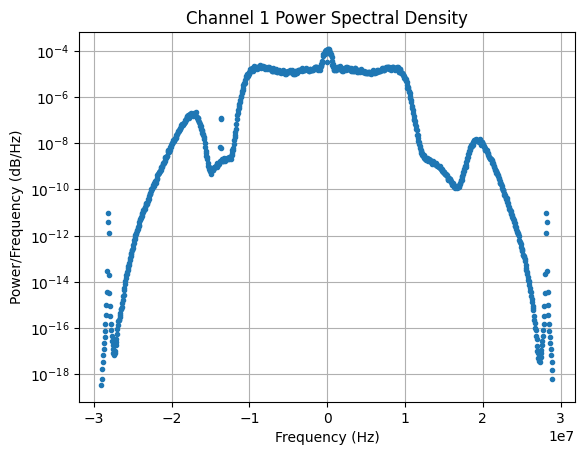

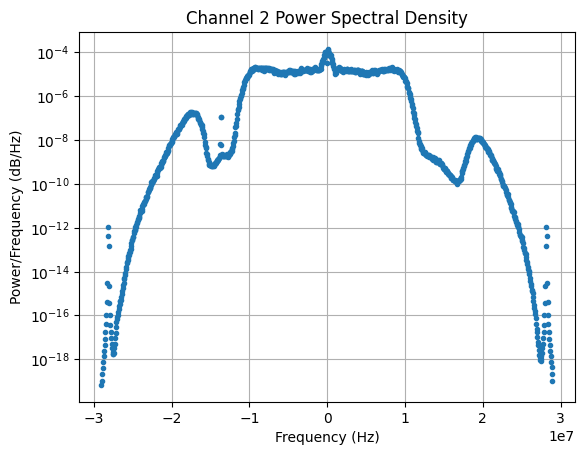

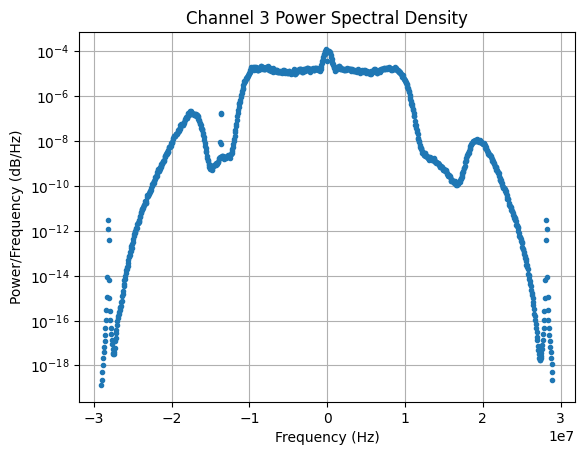

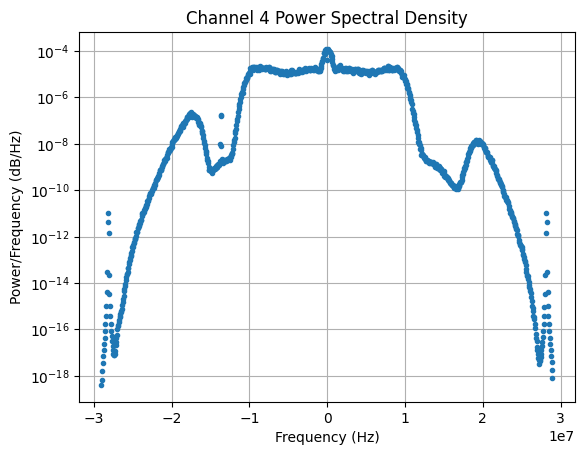

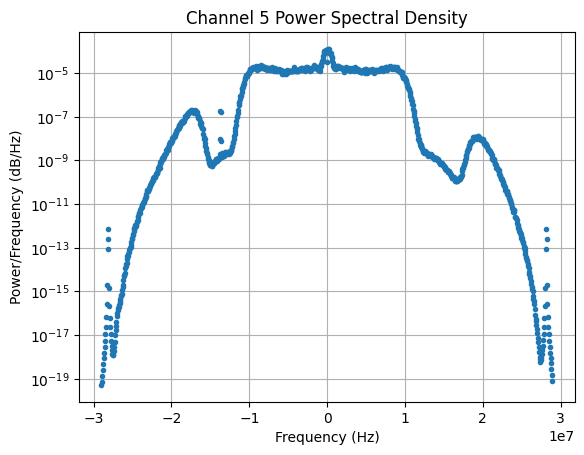

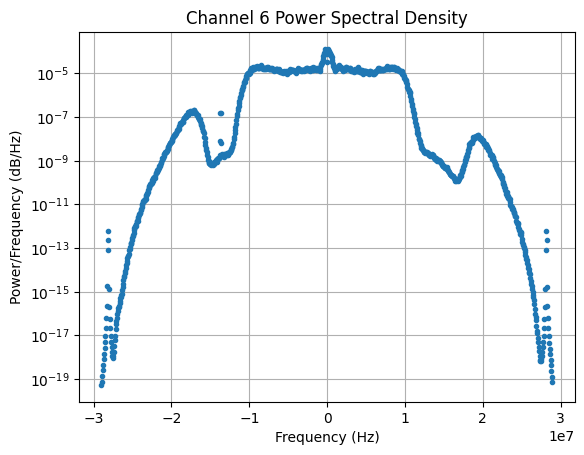

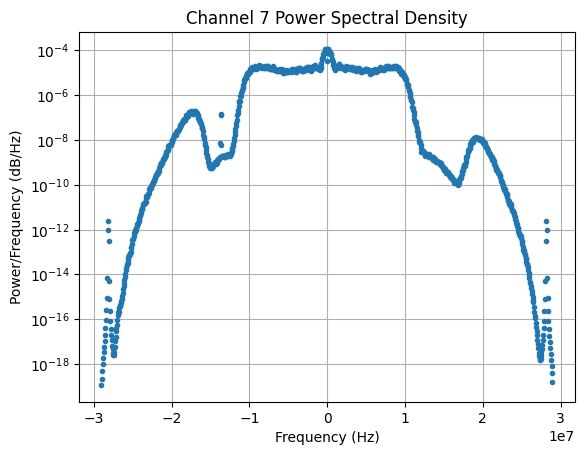

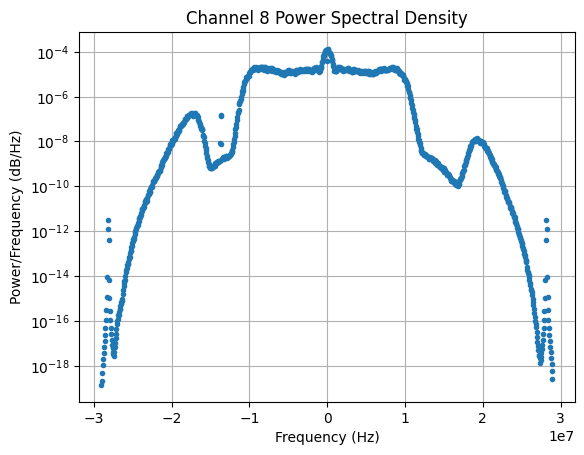

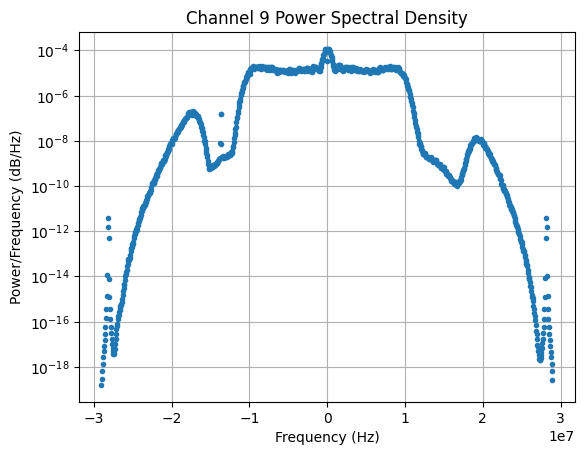

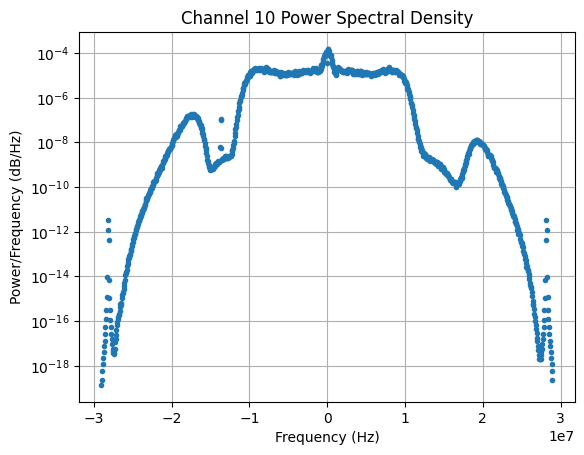

In [23]:
input_file_path = '/home/cosgrma/workspace/sergeant/data/mcode_8bit_4chan_1min.bin'
output_file_base_path = 'path_to_output_baseband'
if_freq = 13.68e6  # Intermediate frequency
original_sample_rate = 56.32e6  # Original sample rate
target_sample_rate = 58e6  # Target sample rate
T = 1e-3
num_channels = 4
block_size = int(original_sample_rate * T)  # Number of samples per block

sp = SignalProcessor(input_file_path, output_file_base_path, if_freq, original_sample_rate, target_sample_rate, block_size)
sp.process_chunks()

In [6]:
ints = range(0, 100)
ints = np.array(ints)
num_samples = 25

reshaped_data = ints.reshape((num_samples, num_channels))
final_data = reshaped_data.transpose()
print(final_data)
# ints = ints.reshape(4, 25)

[[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92
  96]
 [ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93
  97]
 [ 2  6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78 82 86 90 94
  98]
 [ 3  7 11 15 19 23 27 31 35 39 43 47 51 55 59 63 67 71 75 79 83 87 91 95
  99]]


I have a vector that has samples from 4 channels as a numpy array. 
The array is structured like this:
`[s1_c1, s1_c2, s1_c3, s1_c4, s2_c1, s2_c2, s2_c3, s2_c4, ...]`
I want to reshape so it is like this:
`[[s1_c1, s2_c1, ...],[s1_c2, s2_c2, ...]`